In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

In [4]:
data1 = pd.read_csv('./Sonidos de casa/data_momento_aux.csv')
data2 = pd.read_csv('./Sonidos de casa/data_momento_aux_shaver.csv')
data3 = pd.read_csv('./Sonidos de casa/data_momento_aux_hairdryer.csv')
data4 = pd.read_csv('./Sonidos de casa/data_momento_aux_airconditioner.csv')
data5 = pd.read_csv('./Sonidos de casa/data_momento_aux_cellphone.csv')
data6 = pd.read_csv('./Sonidos de casa/data_momento_aux_comp_type.csv')
data7 = pd.read_csv('./Sonidos de casa/data_momento_aux_shower.csv')
data8 = pd.read_csv('./Sonidos de casa/data_momento_aux_vacuum_silence_dryer.csv')
data9 = pd.read_csv('./Sonidos de casa/data_momento_aux_blender_doorbell.csv')
data10 = pd.read_csv('./Sonidos de casa/data_momento_aux_alarm_faucet_microwave.csv')

data = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10])

In [5]:
data.head()

,mfcc,scem,scom,srom,sbwm,tempo,rmse,momento_aux
0,8.496989,712.836354,20.288098,821.184439,1649.203780,123.046875,0.224968,Lavadora
1,-0.570672,3331.769238,17.851447,6729.850411,2802.241131,123.046875,0.142873,Aspiradora
2,-33.519966,3041.652499,25.822745,4911.568754,1606.222710,135.999178,0.013394,Ducha
3,4.767383,1660.236818,18.631205,4236.657715,2572.411617,120.000000,0.142544,Lavadora
4,4.888659,881.912702,17.027614,1765.397910,1488.700377,117.453835,0.128794,Lavadora


In [6]:
data.shape

(2961, 8)

In [7]:
data.describe()

,mfcc,scem,scom,srom,sbwm,tempo,rmse
count,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000
mean,-9.298735,2557.744559,19.635431,4833.775799,2183.997756,124.919987,0.092519
std,10.146918,1488.022002,3.483622,2707.707056,759.975619,14.340122,0.075292
min,-56.568542,0.000000,0.000000,0.000000,0.000000,83.354335,0.000000
25%,-15.975185,1262.656881,17.409630,2157.916727,1592.859134,117.453835,0.028839
50%,-8.861495,2570.938461,18.696572,5052.009204,2455.881733,123.046875,0.068703
75%,-2.466966,3424.361834,21.537844,7380.392959,2808.579298,129.199219,0.151704
max,9.566074,6438.882531,37.151258,9727.624512,3437.618460,215.332031,0.288975


In [8]:
data.dtypes

mfcc           float64
scem           float64
scom           float64
srom           float64
sbwm           float64
tempo          float64
rmse           float64
momento_aux     object
dtype: object

In [9]:
data.isna().sum()

mfcc           0
scem           0
scom           0
srom           0
sbwm           0
tempo          0
rmse           0
momento_aux    0
dtype: int64

In [10]:
data.momento_aux.value_counts()

Lavadora              244
Licuadora             208
Tecleo                196
Secadora              196
Alarma                194
Grifo                 185
Timbre                183
Secador_pelo          183
Ducha                 183
Microondas            183
Aire_acondicionado    182
Afeitadora            182
Silencio              181
Aspiradora            179
Telefono              152
Cena                  130
Name: momento_aux, dtype: int64

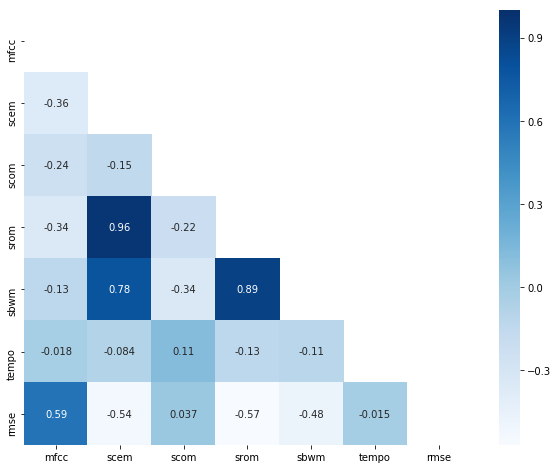

In [11]:
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(data.corr(), mask=mask, annot=True, cmap="Blues")

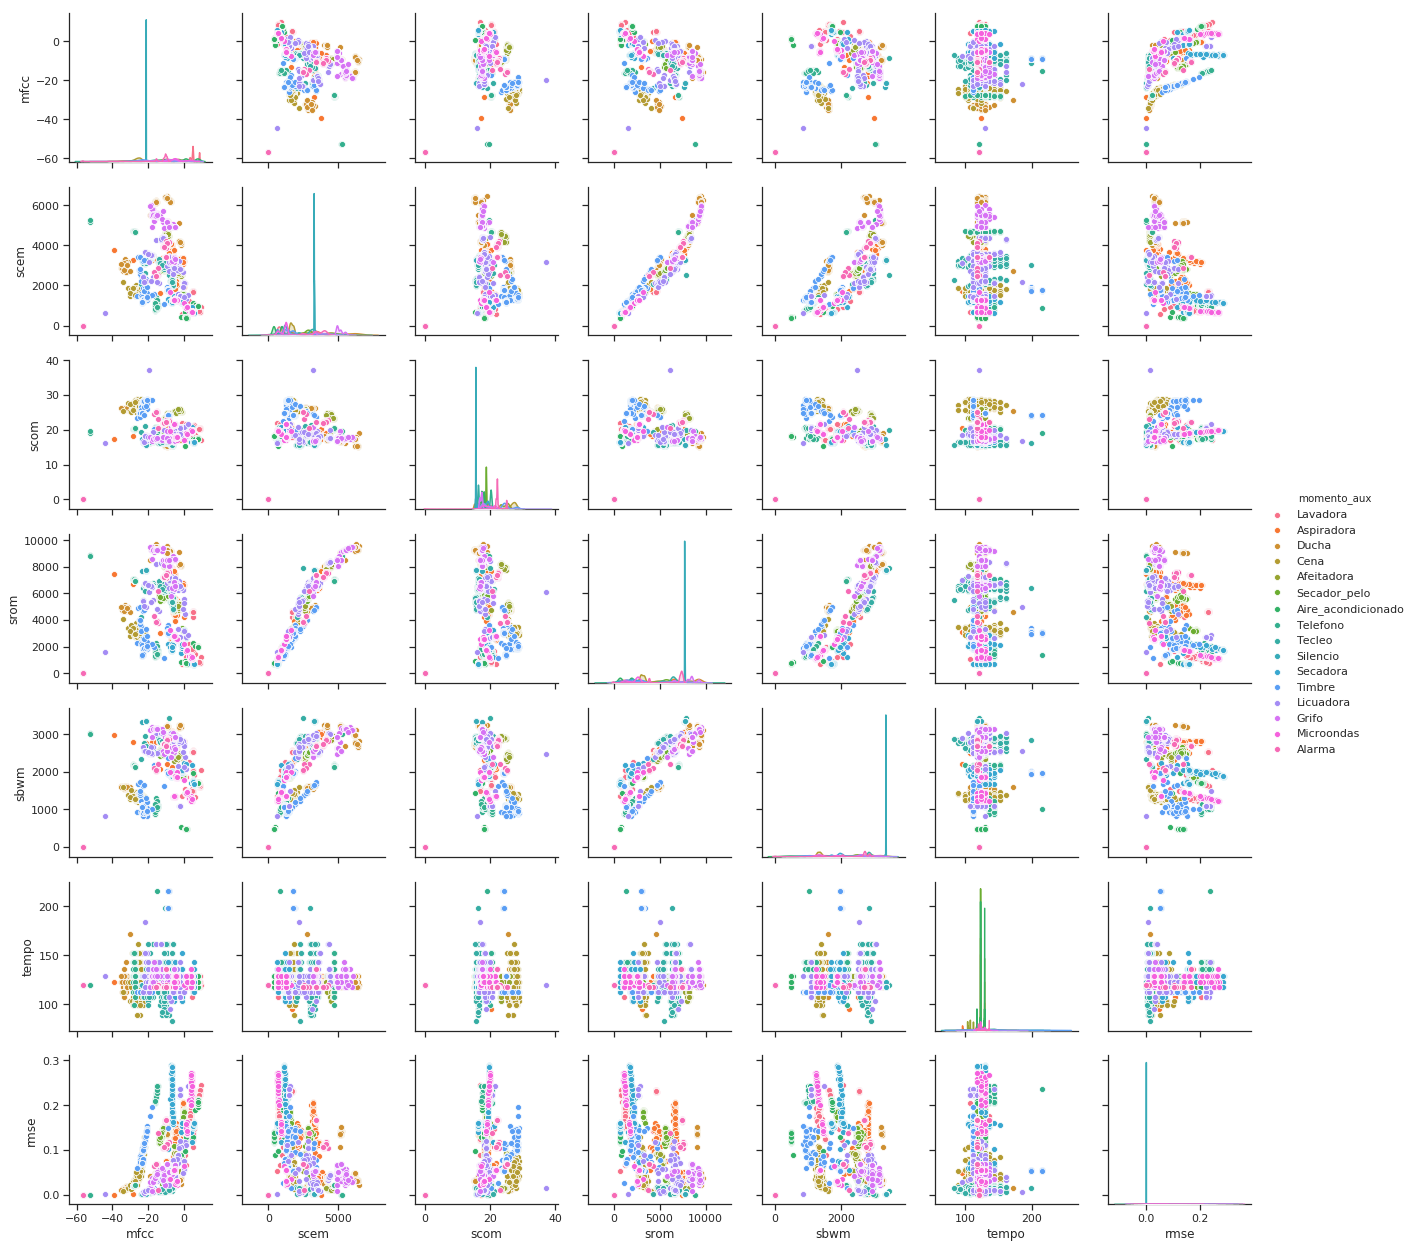

In [12]:
sns.set(style="ticks")

sns.pairplot(data, hue="momento_aux")

In [13]:
y = pd.get_dummies(data=data.momento_aux)
X = data.loc[:, data.columns != 'momento_aux']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [21]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
scores = cross_val_score(clf, X, y, cv=20)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.97986577 0.92567568 0.92567568 0.95945946 1.         0.92567568
 0.98648649 0.17567568 0.95945946 0.95945946 0.98648649 0.9527027
 0.97297297 0.93918919 0.85810811 0.91216216 0.97297297 0.99324324
 0.96621622 0.9527027 ]
Accuracy: 0.92 (+/- 0.35)


In [22]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9612141652613828

In [23]:
predictions = clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.00
Aire_acondicionado    0.00
Alarma                0.00
Aspiradora            0.01
Cena                  0.00
Ducha                 0.00
Grifo                 0.00
Lavadora              0.01
Licuadora             0.00
Microondas            0.00
Secador_pelo          0.00
Secadora              0.01
Silencio              0.00
Tecleo                0.01
Telefono              0.00
Timbre                0.00
dtype: float64 degrees.


In [24]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [25]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [26]:
indices = np.argsort(importances)[::-1]

In [27]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.206975)
2. feature 4 (0.186962)
3. feature 0 (0.160920)
4. feature 1 (0.152600)
5. feature 6 (0.148053)
6. feature 3 (0.118061)
7. feature 5 (0.026429)


,importance
scom,0.206975
sbwm,0.186962
mfcc,0.160920
scem,0.152600
rmse,0.148053
srom,0.118061
tempo,0.026429


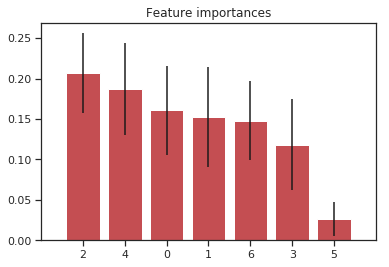

In [28]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [29]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9645868465430016

In [30]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9657934608187198

In [31]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.728571,1.000000,0.842975
Ducha,1.000000,1.000000,1.000000
Lavadora,1.000000,0.947368,0.972973
Aspiradora,1.000000,0.926829,0.962025
Afeitadora,1.000000,0.964286,0.981818
Secador_pelo,1.000000,0.966667,0.983051
Aire_acondicionado,1.000000,0.971429,0.985507
Telefono,0.964912,0.948276,0.956522
Tecleo,1.000000,0.942857,0.970588


Confusion matrix, without normalization
[[51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0 29  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 34  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0 55  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0 32  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0 32  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  1  0  0  0 38  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0 38  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0 34  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 24  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 36]]


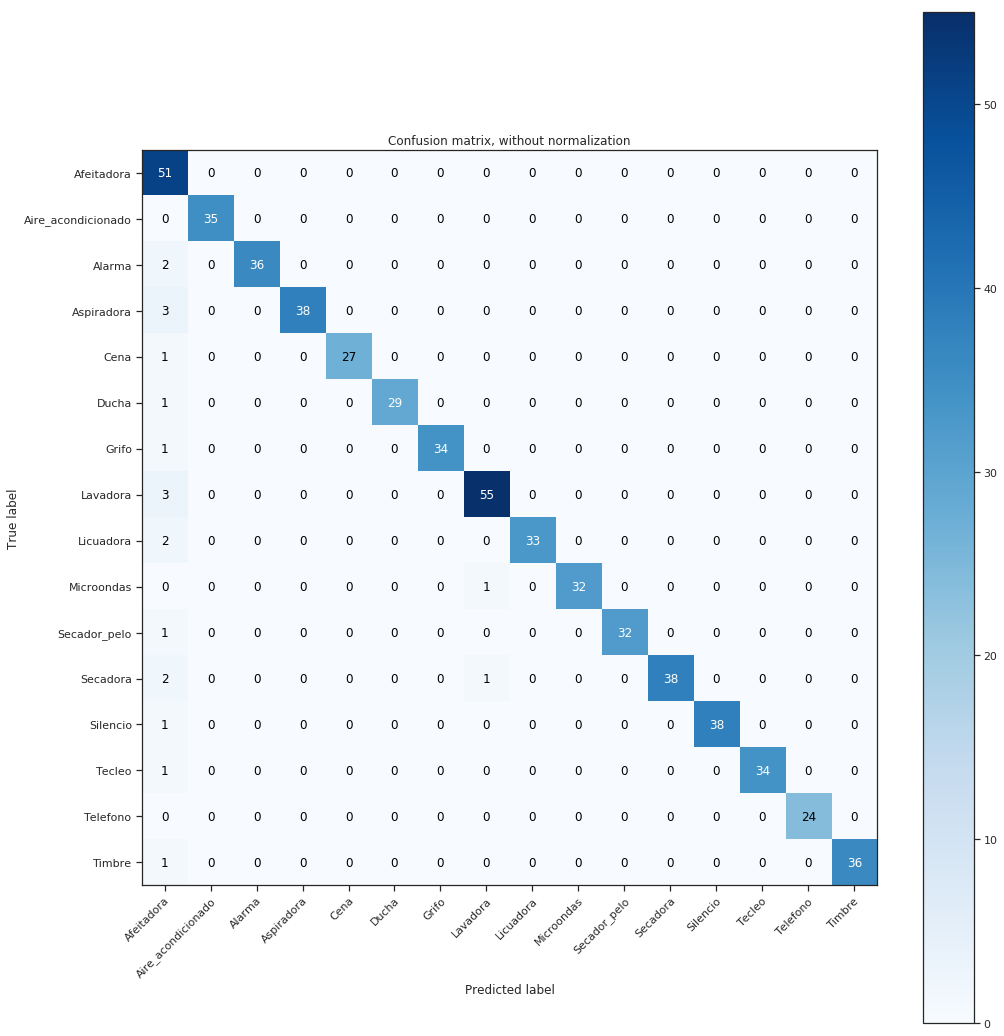

In [32]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [33]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [35]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [36]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [37]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [38]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [39]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [40]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

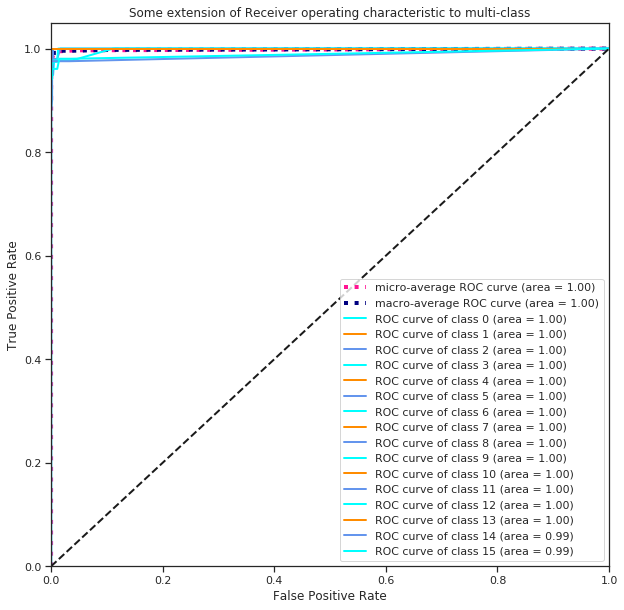

In [41]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()